**Autocodificadores.**

*Un codificador aprende cómo reducir la entrada a su característica latente (usando convolución, como una CNN). Un decodificador aprende a reconstruir datos a partir de esas características latentes (¡usando la convolución de transposición!) El sistema en su conjunto está entrenado de tal manera que la entrada original alimentada en el codificador sea lo más cercana posible a los datos reconstruidos generados por el decodificador. Una vez entrenado, podemos descartar el codificador y simplemente usar el decodificador para crear datos sintéticos. Aplicaciones: reducción de dimensionalidad, compresión, búsqueda, eliminación de ruido, coloración*

**Transponer convolución.**

*El decodificador utiliza capas Conv2DTranspose para reconstruir imágenes a partir de sus entidades latentes. Aprende los pesos utilizados para crear nuevos píxeles de imagen a partir de representaciones de dimensiones inferiores. Bueno, se puede usar en más que solo imágenes. A menudo se usa zancada de 2. Puede usar max-unpooling (inverse max-pooling). Piense en el decodificador como una CNN que funciona al revés*

**Autocodificadores variacionales.**

*En un VAE, los vectores latentes son distribuciones de probabilidad (así). Representada por la media y la varianza de las distribuciones normales gaussianas. X -> p(z/X) -> z -> p(X/z). Esta es la inspiración de las redes generativas antagónicas (GAN): estamos llegando allí*


**El "truco de la reparametrización".**

*Un problema con la idea VAE es que la distribución de probabilidad (z) no se puede diferenciar. Y necesitamos derivados para que la retropropagación funcione. El "truco" es convertir el muestreo aleatorio de z a una forma determinista: Z=mu+sigma* épsilon. Aquí, épsilon es la variable aleatoria (de una distribución normal estándar). Eso empuja el paso aleatorio fuera de la red como una entrada, dando como un gráfico conectado*


**Divergencia kullback-Leibler.**

*¿Cómo medimos la distancia entre dos distribuciones de probabilidad de los datos originales y reconstruidos? Se utiliza KL Divergence. A veces llamada "distancia de movimiento de tierra". Divergencia KL = E p(x)*log(p(x)/q(x)). Equivalente a entropía cruzada (p,q) - entropía (p). A veces llamada "entropía relativa". Lo usamos como una función de pérdida. kl_loss=-0.5 * (1 + z_log_var-tf.square(z_mean)-tf.exp(z_log_var))*

**Este cuaderno cubre el entrenamiento de un VAE en el conjunto de datos FashionMNIST.**

*En las siguientes secciones, deberemos:*

1. Explore el conjunto de datos de FashionMNIST
2. Implementar una capa de muestreo personalizada
3. Implementar modelos de codificador/decodificador utilizando API funcionales
4. Implementar funciones de pérdida
5. Anular el modelo Keras train_step
6. Entrena el modelo VAE
7. Explora los resultados

In [1]:
import tensorflow as tf
import os
import random
import numpy as np

# confirm GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


*También establezcamos una semilla aleatoria consistente para ayudar a que los resultados de este cuaderno sean más, bueno, consistentes.*

In [2]:
SEED = 123456
os.environ['PYTHONHASHSEED']=str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # new flag present in tf 2.0+
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Explorando el conjunto de datos de FashionMNIST ##

*FashionMNIST es como el conjunto de datos MNIST de reconocimiento de escritura a mano que conocemos y amamos, pero con imágenes de diferentes tipos de ropa en lugar de imágenes de personas escribiendo dígitos.*

<h2>Etiquetas/clases disponibles</h2>

<table align="left">
<thead>
<tr>
<th align="center">Label</th>
<th>Description</th>
</tr>
</thead>
<tbody>
<tr>
<td align="center">0</td>
<td>T-shirt/top</td>
</tr>
<tr>
<td align="center">1</td>
<td>Trouser</td>
</tr>
<tr>
<td align="center">2</td>
<td>Pullover</td>
</tr>
<tr>
<td align="center">3</td>
<td>Dress</td>
</tr>
<tr>
<td align="center">4</td>
<td>Coat</td>
</tr>
<tr>
<td align="center">5</td>
<td>Sandal</td>
</tr>
<tr>
<td align="center">6</td>
<td>Shirt</td>
</tr>
<tr>
<td align="center">7</td>
<td>Sneaker</td>
</tr>
<tr>
<td align="center">8</td>
<td>Bag</td>
</tr>
<tr>
<td align="center">9</td>
<td>Ankle boot</td>
</tr>
</tbody>
</table>




*Vamos a importar el conjunto de datos y comprobar sus dimensiones. Cada imagen es de 28x28, con 60000 muestras de entrenamiento y 10000 de prueba.*

In [3]:
from tensorflow.keras.datasets import fashion_mnist


(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

4422102/4422102 [==============================] - 3s 1us/step


*Siempre es una buena idea inspeccionar los datos y tener una idea de ellos, así que visualicemos algunas muestras para ver cómo se ven.*

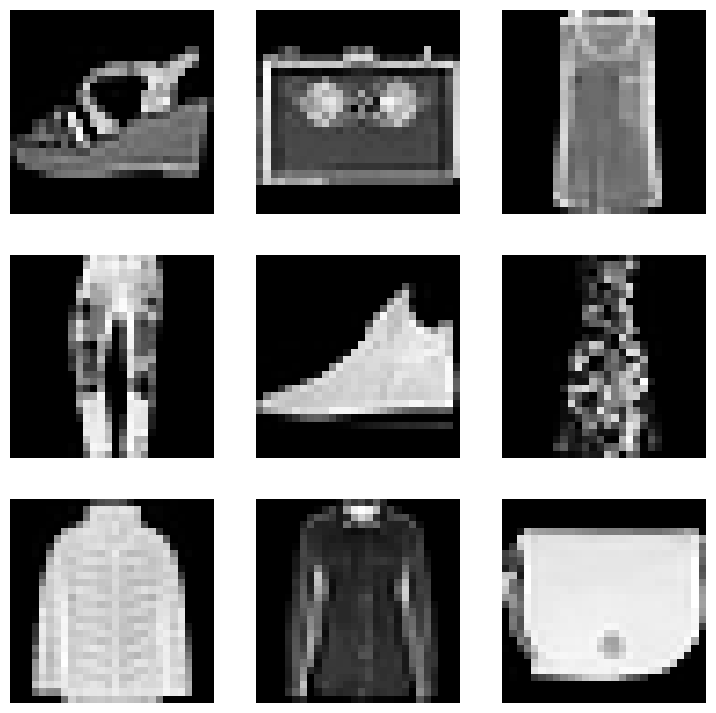

In [4]:
import numpy as np
from matplotlib import pyplot as plt

plt.figure(figsize=(9, 9))

# Choose 9 samples out of 60K available in the train set
rndSamples = np.random.choice(60000, 9)

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x_train[rndSamples[i]], cmap="Greys_r")
    plt.axis('off')

plt.show();

*Necesitamos preprocesar los datos un poco antes de que sean adecuados para su uso con modelos generativos. Primero, vamos a combinar nuestros datos de entrenamiento y prueba porque los modelos generativos no funcionan a través de la precisión de clasificación de medición de tren / prueba, miden qué tan similares son las imágenes generadas al original, utilizando métodos de percepción visual como FID / IS (Frechet Inception Distance and Inception Score). Así que realmente solo necesitamos una gran pila de imágenes.*

*También necesitamos normalizar los datos; Los datos de píxeles sin procesar están en el rango 0-255, pero los valores de activación sigmoide son 0-1, por lo que escalaremos todos los píxeles a 0-1 simplemente dividiéndolos por 255.*

*Y, necesitamos agregar una dimensión adicional ya que las capas convolucionales esperan 3 canales.*

In [5]:
dataset = np.concatenate([x_train, x_test], axis=0)
# Please note expand_dims converts images from 28x28 to 28x28x1
# Since convolutional layers expect 3 channels
dataset = np.expand_dims(dataset, -1).astype("float32") / 255

## Capa de muestreo personalizada ##

*Nuestro codificador está tratando de aprender una distribución de probabilidad z dados los datos X. La distribución está definida por Mu y Sigma.*

*Luego, el decodificador muestra aleatoriamente de la distribución z.*

*El problema es que el muestreo aleatorio no es diferenciable, lo cual es necesario para el entrenamiento de retropropagación. Pero al introducir un parámetro Epsilon lo convertimos en una operación determinista y diferenciable.*

In [6]:
from tensorflow import keras
from tensorflow.keras import layers


# Create a sampling layer
class SamplingLayer(layers.Layer):
  """Reparameterization Trick z = mu + sigma * epsilon"""

  def call(self, inputs):
    zMean, zLogVar = inputs
    batch = tf.shape(zMean)[0]
    dim = tf.shape(zMean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return zMean + tf.exp(0.5 * zLogVar) * epsilon

## Codificador / Decodificador ##

*Nuestro codificador utiliza las API funcionales de Keras para crear un modelo no secuencial, ya que necesitamos generar dos valores en paralelo (media y varianza).*

In [7]:
def buildEncoder(latentDim, encoderInputs):

  # Given a batch of images the convolutional block extracts the features
  l1 = keras.models.Sequential([
    layers.Conv2D(128, 3, activation="relu", strides=2, padding="same"),
    layers.Conv2D(64, 3, activation="relu", strides=2, padding="same"),
    layers.Flatten(),
    layers.Dense(256, activation="relu")
  ])

  # pass the inputs through the convolutional block
  x = l1(encoderInputs)

  # a dedicated layer to learn mean in parallel
  zMean = layers.Dense(latentDim, name="z_mean")(x)

  # a dedicated layer to learn variance in parallel
  zLogVar = layers.Dense(latentDim, name="z_log_var")(x)

  # now the reparametrization trick to find z as defined by mean and variance
  z = SamplingLayer()([zMean, zLogVar])

  # the actual model which takes the images as input and returns mean, variance, and distribution
  # please note the zMean and zLogVar are not the final output of the encoder, but
  # they are used in the Kullback-Leibler Divergence Loss (explained below)
  return keras.Model(encoderInputs, [zMean, zLogVar, z], name="encoder")

# trigger the function to actually build the model
encoderInputs = keras.Input(shape=(28, 28, 1))
encoder = buildEncoder(2, encoderInputs)
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 256)          878144      ['input_1[0][0]']                
                                                                                                  
 z_mean (Dense)                 (None, 2)            514         ['sequential[0][0]']             
                                                                                                  
 z_log_var (Dense)              (None, 2)            514         ['sequential[0][0]']             
                                                                                            

*Y ahora implementaremos el decodificador de manera similar. Tenga en cuenta el uso de Conv2DTranspose en lugar de Conv2D; Utilizamos la circunvolución de transposición para generar imágenes que van de resoluciones más bajas a resoluciones más altas. Ese es el verdadero corazón de esta técnica.*

In [8]:
def buildDecoder(latentInputs):

  l1 = keras.models.Sequential([
    layers.Dense(7*7*64, activation="relu", input_shape=(latentInputs.shape[1],)),
    layers.Reshape((7,7,64)),
    layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same"),
    layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same"),
    layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")
  ])

  return keras.Model(latentInputs, l1(latentInputs), name="decoder")

# build the actual model
latentInputs = keras.Input(shape=(2,))
decoder = buildDecoder(latentInputs)
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 sequential_1 (Sequential)   (None, 28, 28, 1)         157633    
                                                                 
Total params: 157,633
Trainable params: 157,633
Non-trainable params: 0
_________________________________________________________________


## Funciones de pérdida ##

*¡VAE tiene DOS funciones de pérdida! Primero está la pérdida de reconstrucción, que penaliza las imágenes que no son similares a las imágenes originales.*

In [9]:
def reconstructionLoss(data, reconstructed):
  return tf.reduce_mean(
      tf.reduce_sum(
          keras.losses.binary_crossentropy(data, reconstructed),
          axis=(1, 2)
      )
  )

*A continuación tenemos la función de pérdida de divergencia de Kullback-Liebler, también llamada pérdida de Earth Mover por la analogía de averiguar cuánta suciedad debe moverse para transformar la forma del Reino Unido a la forma de los Estados Unidos.*

*Lo que realmente hace es medir la distancia entre dos distribuciones de probabilidad. Penaliza el modelo si aprende una distribución de probabilidad "z" que es diferente de la distribución de probabilidad original de los datos "X".*

*Matemáticamente es lo mismo que la entropía cruzada: entropía, lo que significa que funciona bien para la retropropagación y la minimización de la probabilidad logarítmica.*

In [10]:
def klDivergenceLoss(zMean, zLogVar):
  return tf.reduce_mean(
      tf.reduce_sum(
          -0.5 * (1 + zLogVar - tf.square(zMean) - tf.exp(zLogVar)),
          axis=1
      )
  )

*Así que ahora los combinaremos en la función de pérdida total, que solo los pondera y los resume. Piensa en ese peso (alfa) como otro hiperparámetro que puedes sintonizar.*

In [11]:
def calcTotalLoss(data, reconstructed, zMean, zLogVar):
  loss1 = reconstructionLoss(data, reconstructed)
  loss2 = klDivergenceLoss(zMean, zLogVar)
  klWeight = 3.0
  return  loss1, loss2, loss1 + klWeight * loss2

## Anulando train_step ##

*Dado que estamos usando una función de pérdida personalizada en mu y sigma, debemos anular cómo se calcula la pérdida. Necesitamos comparar X_original y X_reconstructed al mismo tiempo al calcular la pérdida de Kullback-Liebler (KL).*

In [12]:
class VAE(keras.Model):
  def __init__(self, encoder, decoder, **kwargs):
    super(VAE, self).__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder
    # register total loss as an observable metric in the model training history
    self.totalLossTracker = keras.metrics.Mean(name="total_loss")
    self.ceLossTracker = keras.metrics.Mean(name="ce_loss")
    self.klLossTracker = keras.metrics.Mean(name="kl_loss")
    
  # This are all observable metrics 
  @property
  def metrics(self):
    return [
        self.totalLossTracker,
        self.ceLossTracker,
        self.klLossTracker
    ]
    # Now calculate loss + calculate gradients + update weights
  def train_step(self, data):
    # Gradient tape is a recording of all gradients for the trainable 
    # weights that need to be updated
    with tf.GradientTape() as tape:
        # forward path
        zMean, zLogVar, z = self.encoder(data)
        reconstruction = self.decoder(z)
        ceLoss, klLoss, totalLoss = calcTotalLoss(data, reconstruction, zMean, zLogVar)
    # backward path
    grads = tape.gradient(totalLoss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

    # keep track of loss
    self.totalLossTracker.update_state(totalLoss)
    self.ceLossTracker.update_state(ceLoss)
    self.klLossTracker.update_state(klLoss)

    # return the loss for history object
    return {
        "total_loss": self.totalLossTracker.result(),
        "ce_loss": self.ceLossTracker.result(),
        "kl_loss": self.klLossTracker.result()
    }

## ¡Entrena al VAE! ##

In [13]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))
history = vae.fit(dataset, epochs=32, batch_size=128)

Epoch 1/32
547/547 [==============================] - 177s 317ms/step - total_loss: 313.0346 - ce_loss: 301.7159 - kl_loss: 3.7729
Epoch 2/32
547/547 [==============================] - 205s 374ms/step - total_loss: 279.0071 - ce_loss: 265.4175 - kl_loss: 4.5297
Epoch 3/32
547/547 [==============================] - 203s 371ms/step - total_loss: 275.5217 - ce_loss: 261.5993 - kl_loss: 4.6407
Epoch 4/32
547/547 [==============================] - 201s 368ms/step - total_loss: 273.6878 - ce_loss: 259.4694 - kl_loss: 4.7394
Epoch 5/32
547/547 [==============================] - 201s 368ms/step - total_loss: 272.5740 - ce_loss: 258.1261 - kl_loss: 4.8160
Epoch 6/32
547/547 [==============================] - 202s 369ms/step - total_loss: 271.4938 - ce_loss: 256.9207 - kl_loss: 4.8577
Epoch 7/32
547/547 [==============================] - 203s 371ms/step - total_loss: 271.0086 - ce_loss: 256.2491 - kl_loss: 4.9198
Epoch 8/32
547/547 [==============================] - 202s 369ms/step - total_loss:

*Visualicemos cómo cambiaron las funciones de pérdida en cada época; Esto puede informar en qué punto tiene sentido detenerse.*

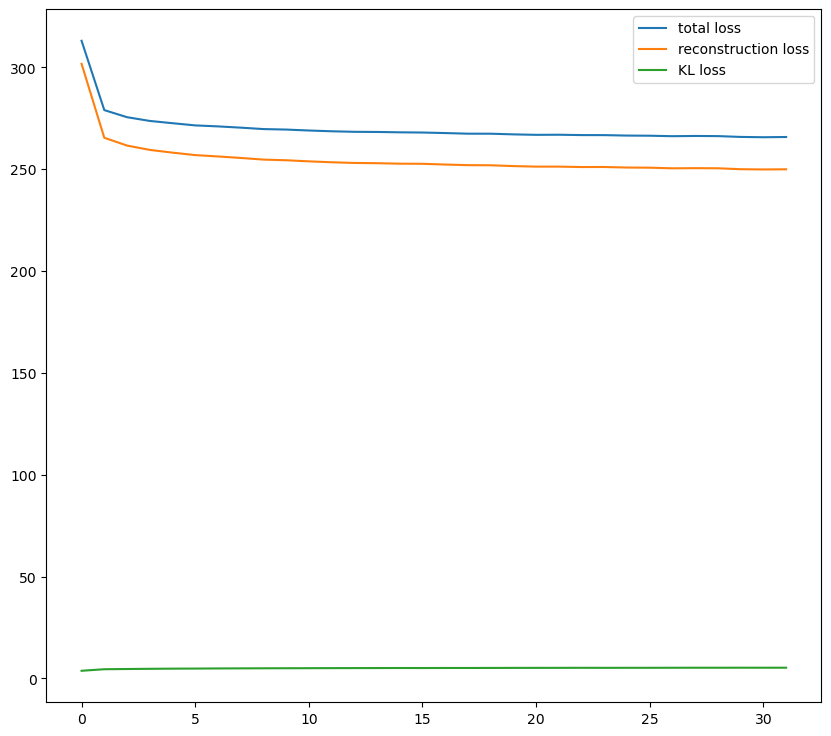

In [14]:
plt.figure(figsize=(10, 9))
plt.plot(history.history.get('total_loss'), label="total loss")
plt.plot(history.history.get('ce_loss'), label="reconstruction loss")
plt.plot(history.history.get('kl_loss'), label="KL loss")
plt.legend();

*Vamos a acercarnos a la pérdida de KL para que podamos verla mejor:*

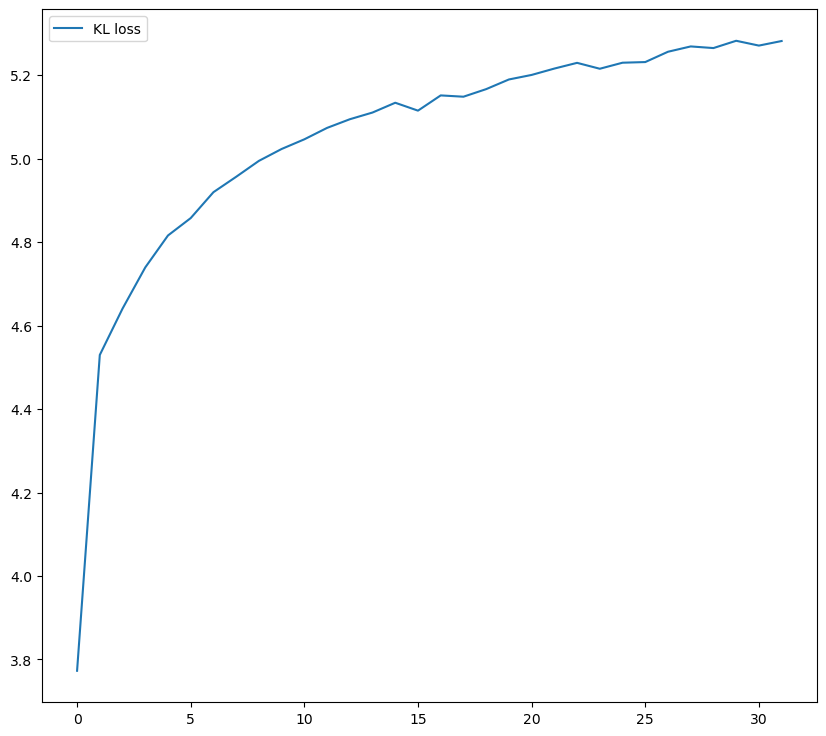

In [15]:
plt.figure(figsize=(10, 9))
plt.plot(history.history.get('kl_loss'), label="KL loss")
plt.legend();

# Explora los resultados ##

Usemos una media (mu) de 1 y una varianza (sigma) de 2 (solo una suposición para empezar). Juegue con esto, pruebe diferentes valores para obtener diferentes tipos de objetos (camisetas, bolsos, etc.)

1/1 [==============================] - 0s 356ms/step


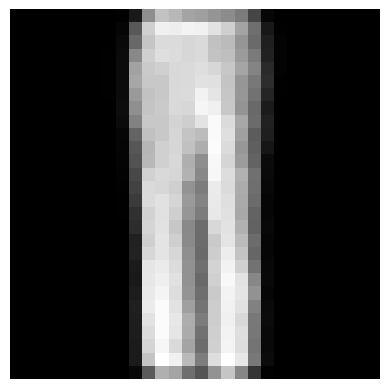

In [16]:
synth = vae.decoder.predict([[1, 2]])
plt.axis('off')
plt.imshow(synth.reshape((28,28)), cmap="Greys_r");

*Vamos a generar 256 imágenes completamente al azar. Todo lo que tenemos que hacer es adivinar la distribución Z (definida por mu, sigma). No se preocupe, llegaremos a un método sistemático para determinar el mu y sigma para cada categoría.*

8/8 [==============================] - 0s 26ms/step


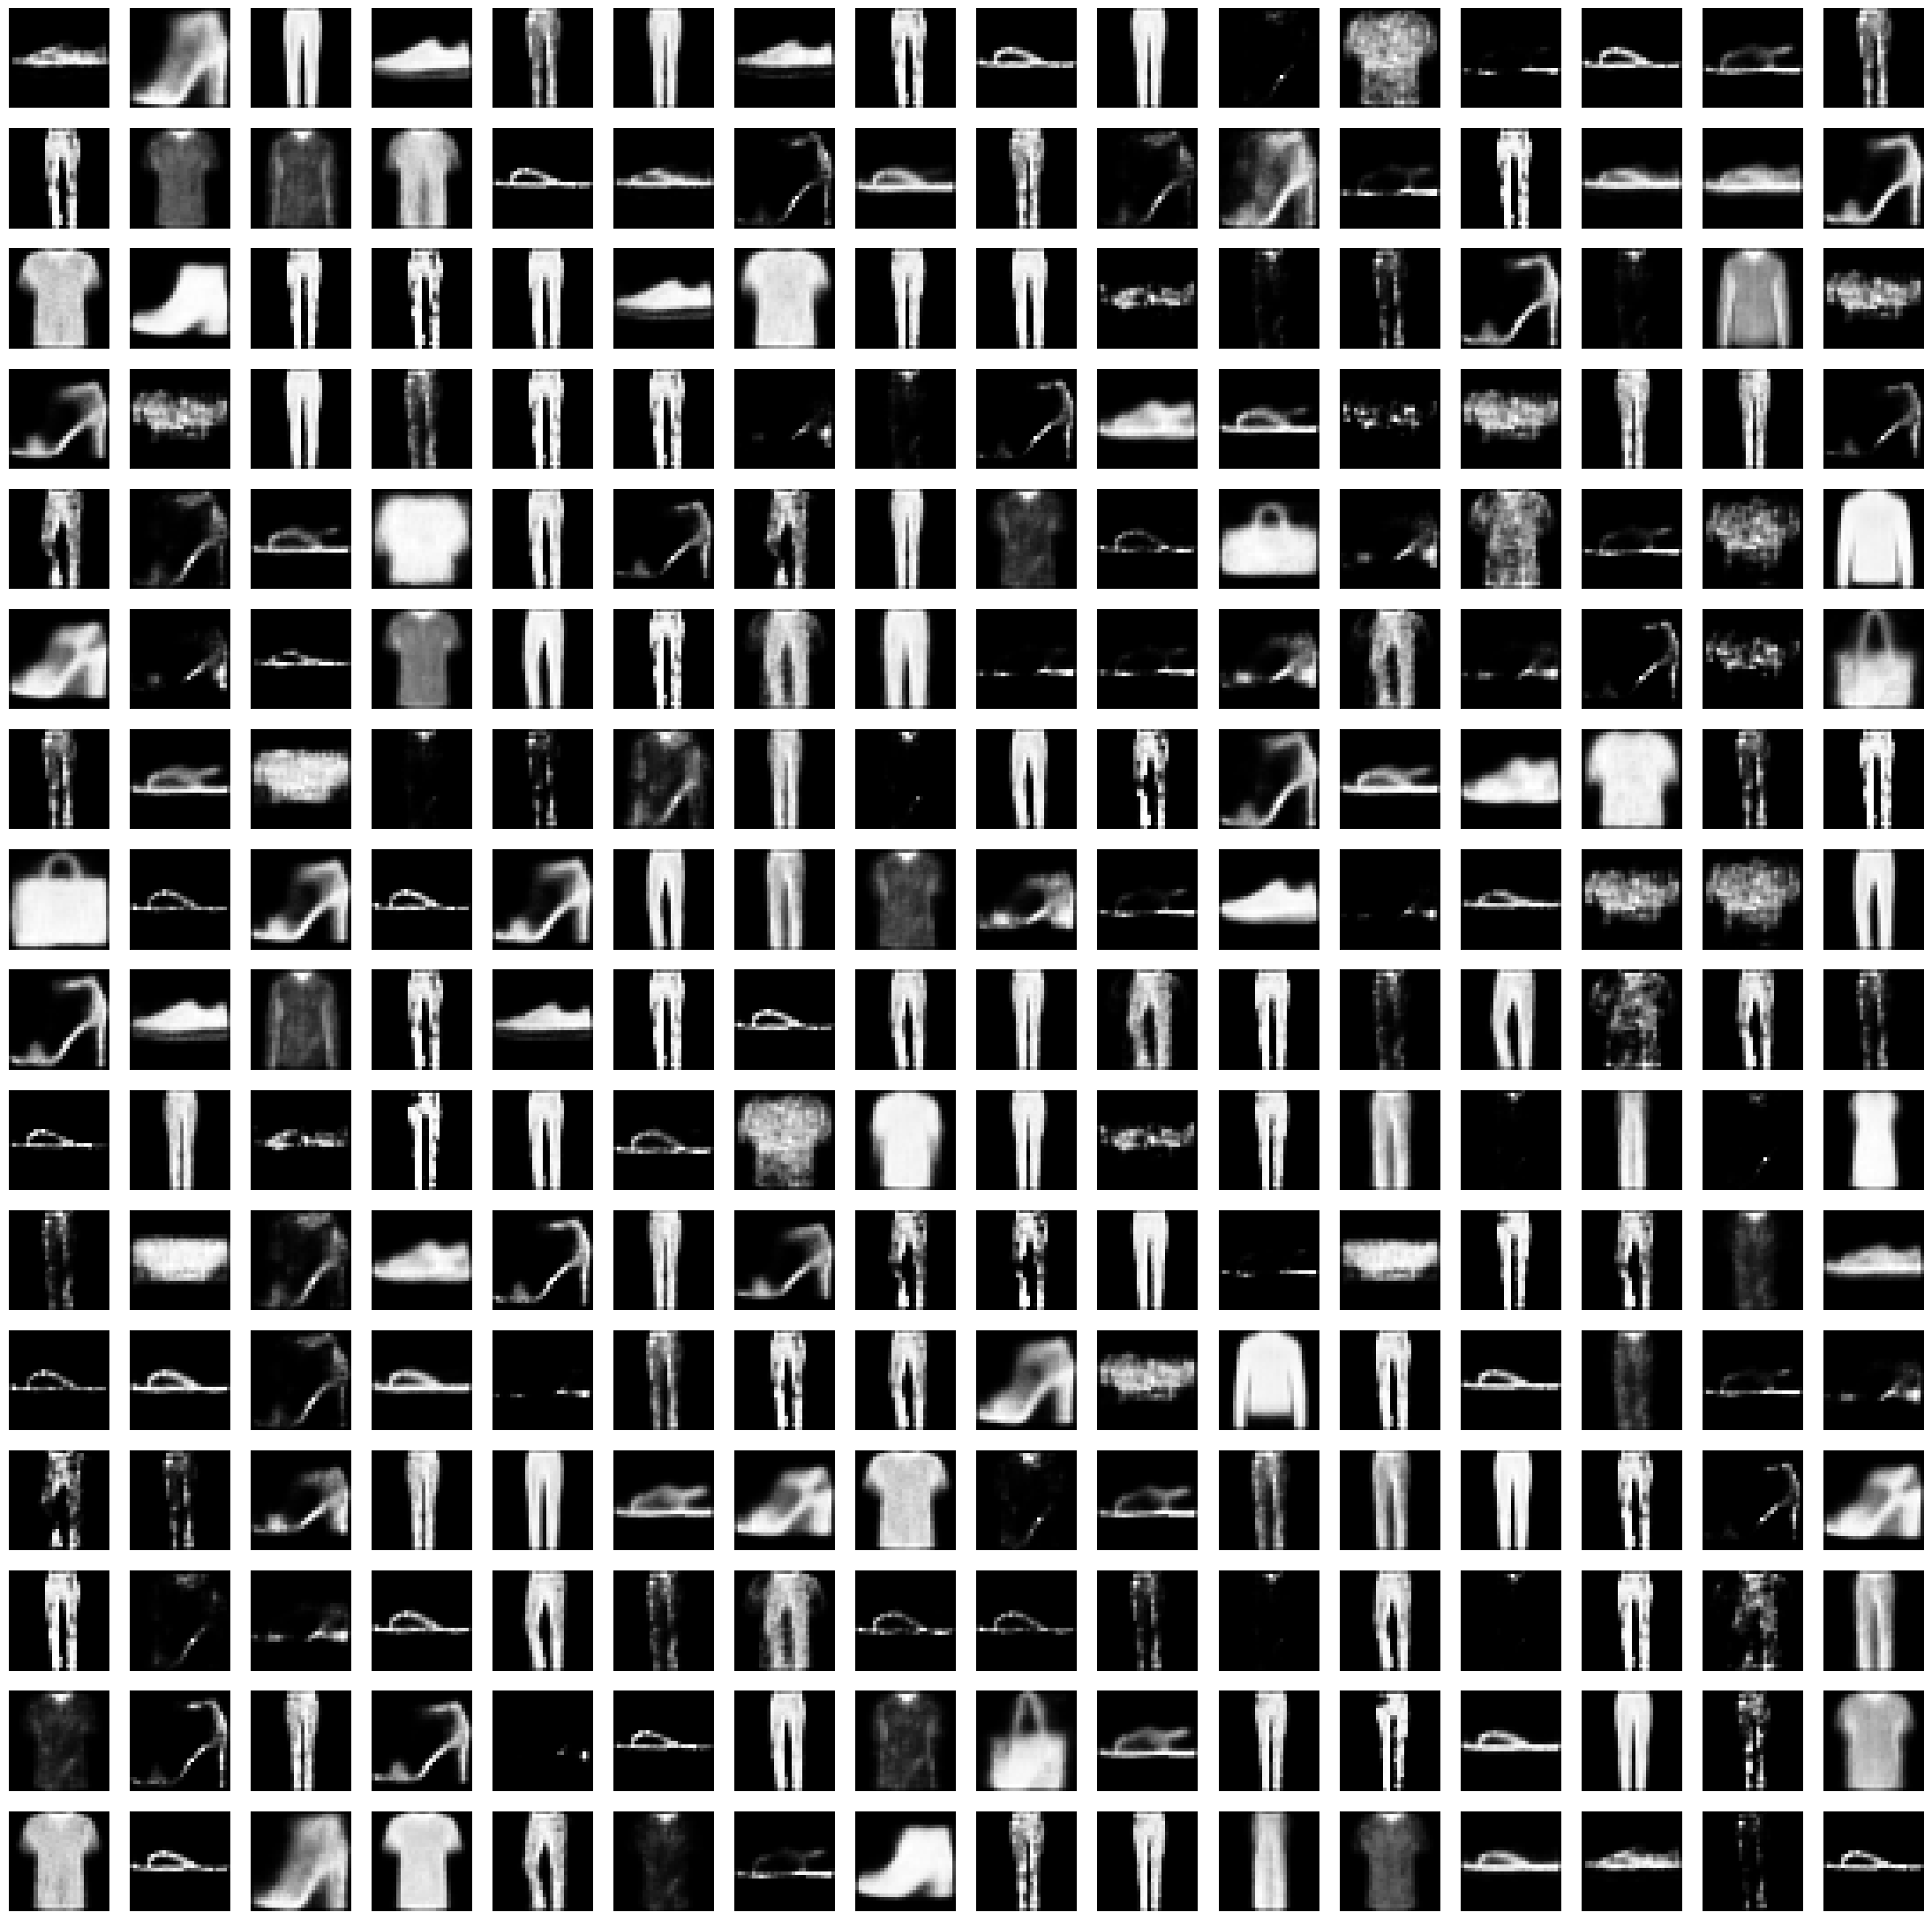

In [17]:
z = np.random.normal(loc=0, scale=4, size=(256,2))
synth = vae.decoder.predict(z)

plt.figure(figsize=(28,28))

for i in range(256):
    plt.subplot(16,16,i+1)
    plt.imshow(synth[i].reshape((28,28)), cmap="Greys_r")
    plt.axis('off')

plt.show();

*Como prometimos, podemos encontrar el mapeo de mu y sigma para cada categoría. Simplemente asigne una imagen de cada categoría a través del codificador y observe la salida. A continuación, utilice esas salidas para indicar condicionalmente al decodificador que muestree de una categoría determinada. Sin embargo, esta no es una solución garantizada: para obtener resultados concretos, busque "Conditional Variational AutoEncoders".*

In [18]:
idx = 1280
batch = np.expand_dims(x_train[idx], axis=0)
batchOfImages = np.expand_dims(batch, axis=-1).astype("float32") / 255
print(batchOfImages.shape)
# obtain z(mu,sigma) for the given image
_, _, z = vae.encoder.predict(batchOfImages)

# now reconstruct a similar image
synth = vae.decoder.predict([z])

z

(1, 28, 28, 1)
1/1 [==============================] - 0s 144ms/step


array([[0.23075174, 1.3283925 ]], dtype=float32)

*Tenga en cuenta que la imagen reconstruida podría ser diferente de la original, dependiendo de cuánto tiempo se haya entrenado el modelo y si ha alcanzado un mínimo global.*

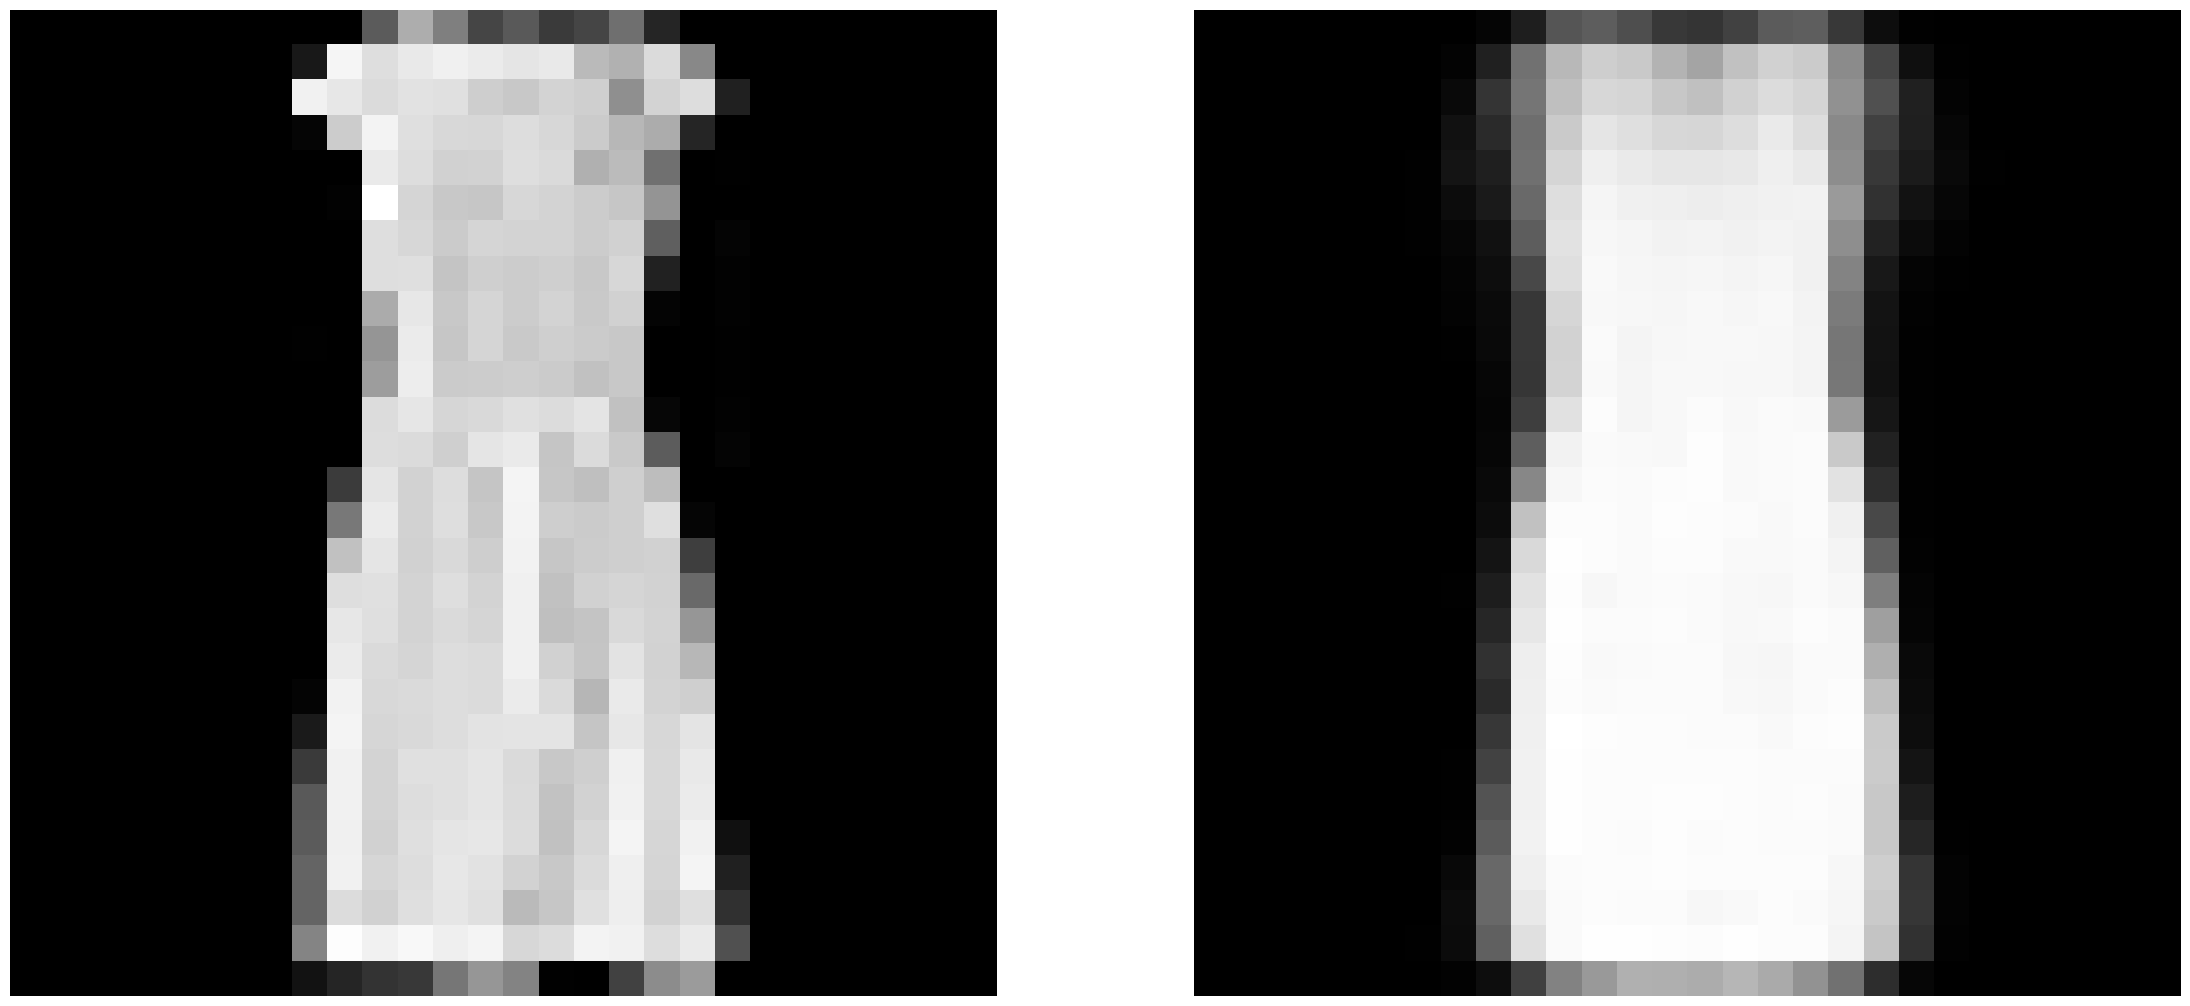

In [19]:
plt.figure(figsize=(28, 28))

# original image
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(x_train[idx], cmap="Greys_r")


# reconstructed
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(synth[0].reshape((28,28)), cmap="Greys_r")
plt.show();

2188/2188 [==============================] - 16s 7ms/step


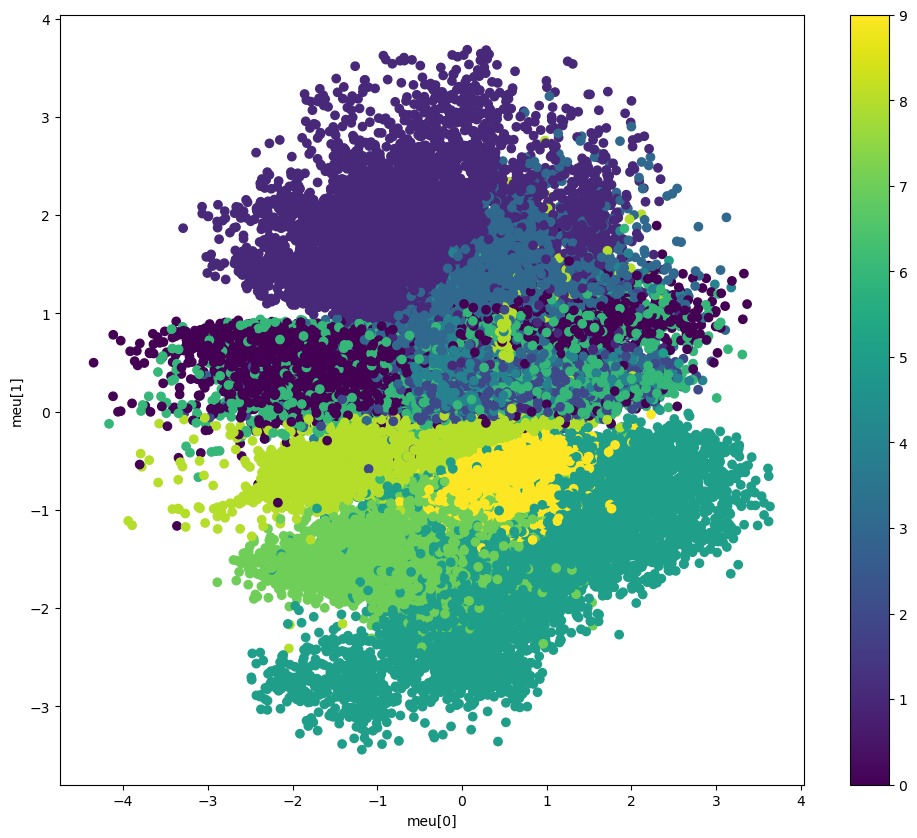

In [20]:
"""VAE se puede utilizar en el aprendizaje no supervisado de texto grande o corpus de imágenes sin etiquetar
Para agrupar las muestras en categorías"""


labels = np.concatenate([y_train, y_test], axis=0)
meu, _, _ = vae.encoder.predict(dataset)
plt.figure(figsize=(12, 10))
plt.scatter(meu[:, 0], meu[:, 1], c=labels)
plt.colorbar()
plt.xlabel("meu[0]")
plt.ylabel("meu[1]")
plt.show();